In [8]:
from dask.optimization import cull
from dask.optimization_compile import compiled, preserve_keys, CompiledFunction, compiled_function_cache
import pickle
import dask
import dask.array as da
import numpy as np

def apply_oz(func, coll, **kwargs):
    dsk = func(coll.__dask_graph__(), coll.__dask_keys__(), **kwargs)
    if type(dsk) is tuple:
        dsk = dsk[0]
    ppfunc, args = coll.__dask_postpersist__()
    return ppfunc(dsk, *args)

def define(apply_markers=False):
    a = da.arange(4, chunks=2)
    a = (a + 1) * (a - 1)
    # We're going to use this node as an input to
    # multiple ones; don't repeat calculations and
    # allow for parallelism. This is only a good idea if the
    # optimized calculation is expensive.
    if apply_markers:
        a = apply_oz(preserve_keys, a, do_compile=True)

    a = ((a < 2) - 10) * ((a > 2) + 10)
    # Showcase deduplication of functions
    if apply_markers:
        a = apply_oz(preserve_keys, a, do_compile=True)
    # An input that can't be decompiled into AST
    a = a + np.array([7, 8, 9, 10])
    a = a.sum() + 3
    return a


da_std, = dask.optimize(define(False))
da_com = apply_oz(cull, apply_oz(compiled, define(True)))
da_std.compute(), da_com.compute()

(-363, -363)

In [9]:
print(len(pickle.dumps(da_std)))
print(len(pickle.dumps(da_com)))
print(pickle.loads(pickle.dumps(da_com)).compute())

2286
2452
-363


In [7]:
print("Vanilla dask")
print("============")
print("definition")
%timeit define(False)
print("optimization")
a = define(False)
%timeit dask.optimize(a)
print("compute")
%timeit da_std.compute(optimize_graph=False)
print("pickle->unpickle")
%timeit pickle.loads(pickle.dumps(da_std))

print()
print("source compiled")
print("===============")
print("definition")
%timeit define(True)
print("optimization")
a = define(True)
%timeit compiled_function_cache.clear(); apply_oz(cull, apply_oz(compiled, a))
print("compute")
%timeit da_com.compute(optimize_graph=False)
print("pickle->unpickle")
%timeit pik = pickle.dumps(da_com); compiled_function_cache.clear(); pickle.loads(pik)

Vanilla dask
definition
2.22 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
optimization
457 µs ± 1.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
compute
5 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
67.9 µs ± 244 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

source compiled
definition
2.18 ms ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
optimization
656 µs ± 586 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
compute
845 µs ± 85.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
pickle->unpickle
252 µs ± 1.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
for k, v in da_com.dask.items():
    if type(v is tuple) and v and isinstance(v[0], CompiledFunction):
        print("=======================")    
        print(k)
        print(v)
        print("-----------------------")
        print(v[0].source)


('add-d1b015c84d9d576ae48156a3dc591573',)
(<CompiledFunction -8225530775057722494>, ('sum-aggregate-5f067ae07e9b42a92001c3c746eca869',))
-----------------------
import _operator
import dask.array.core


def _compiled(dsk_sum_0):
    return dask.array.core._enforce_dtype(dsk_sum_0, 3, enforce_dtype=numpy.int64, enforce_dtype_function=_operator.add)

('sum-c8d4422ddb698899a9931d0fb9c6a68b', 0)
(<CompiledFunction -6665036891056254954>, ('mul-4b771e2a5e4c977ef86e25b089391d9d', 0), array([ 7,  8,  9, 10]))
-----------------------
import dask.array.core
import numpy


def _compiled(dsk_mul_0, ndarray_0):
    dsk_array_0 = dask.array.core.getter_inline(ndarray_0, (slice(0, 4, None), ))
    dsk_rechunk_0 = dsk_array_0[0:2]
    dsk_add_0 = dsk_mul_0 + dsk_rechunk_0
    return numpy.sum(dsk_add_0, axis=(0, ), keepdims=True, dtype=numpy.int64)

('sum-c8d4422ddb698899a9931d0fb9c6a68b', 1)
(<CompiledFunction 2462583112117067147>, ('mul-4b771e2a5e4c977ef86e25b089391d9d', 1), array([ 7,  8,  9, 10]))

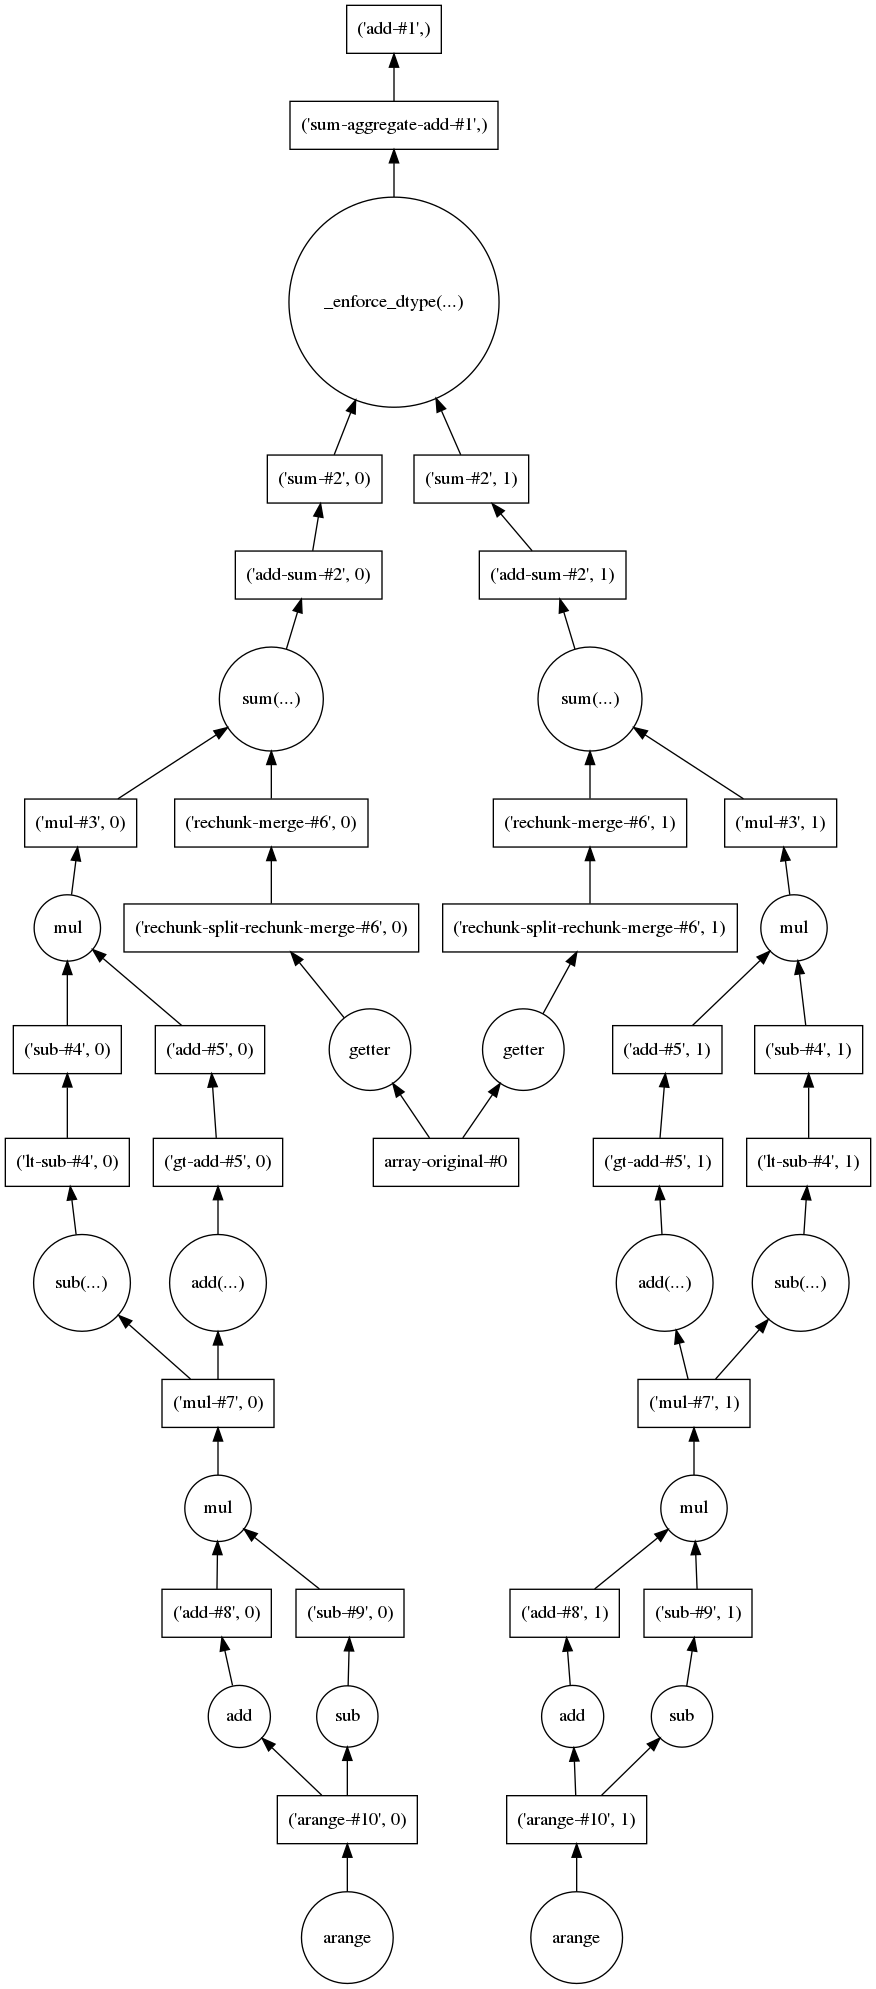

In [11]:
da_std.visualize()

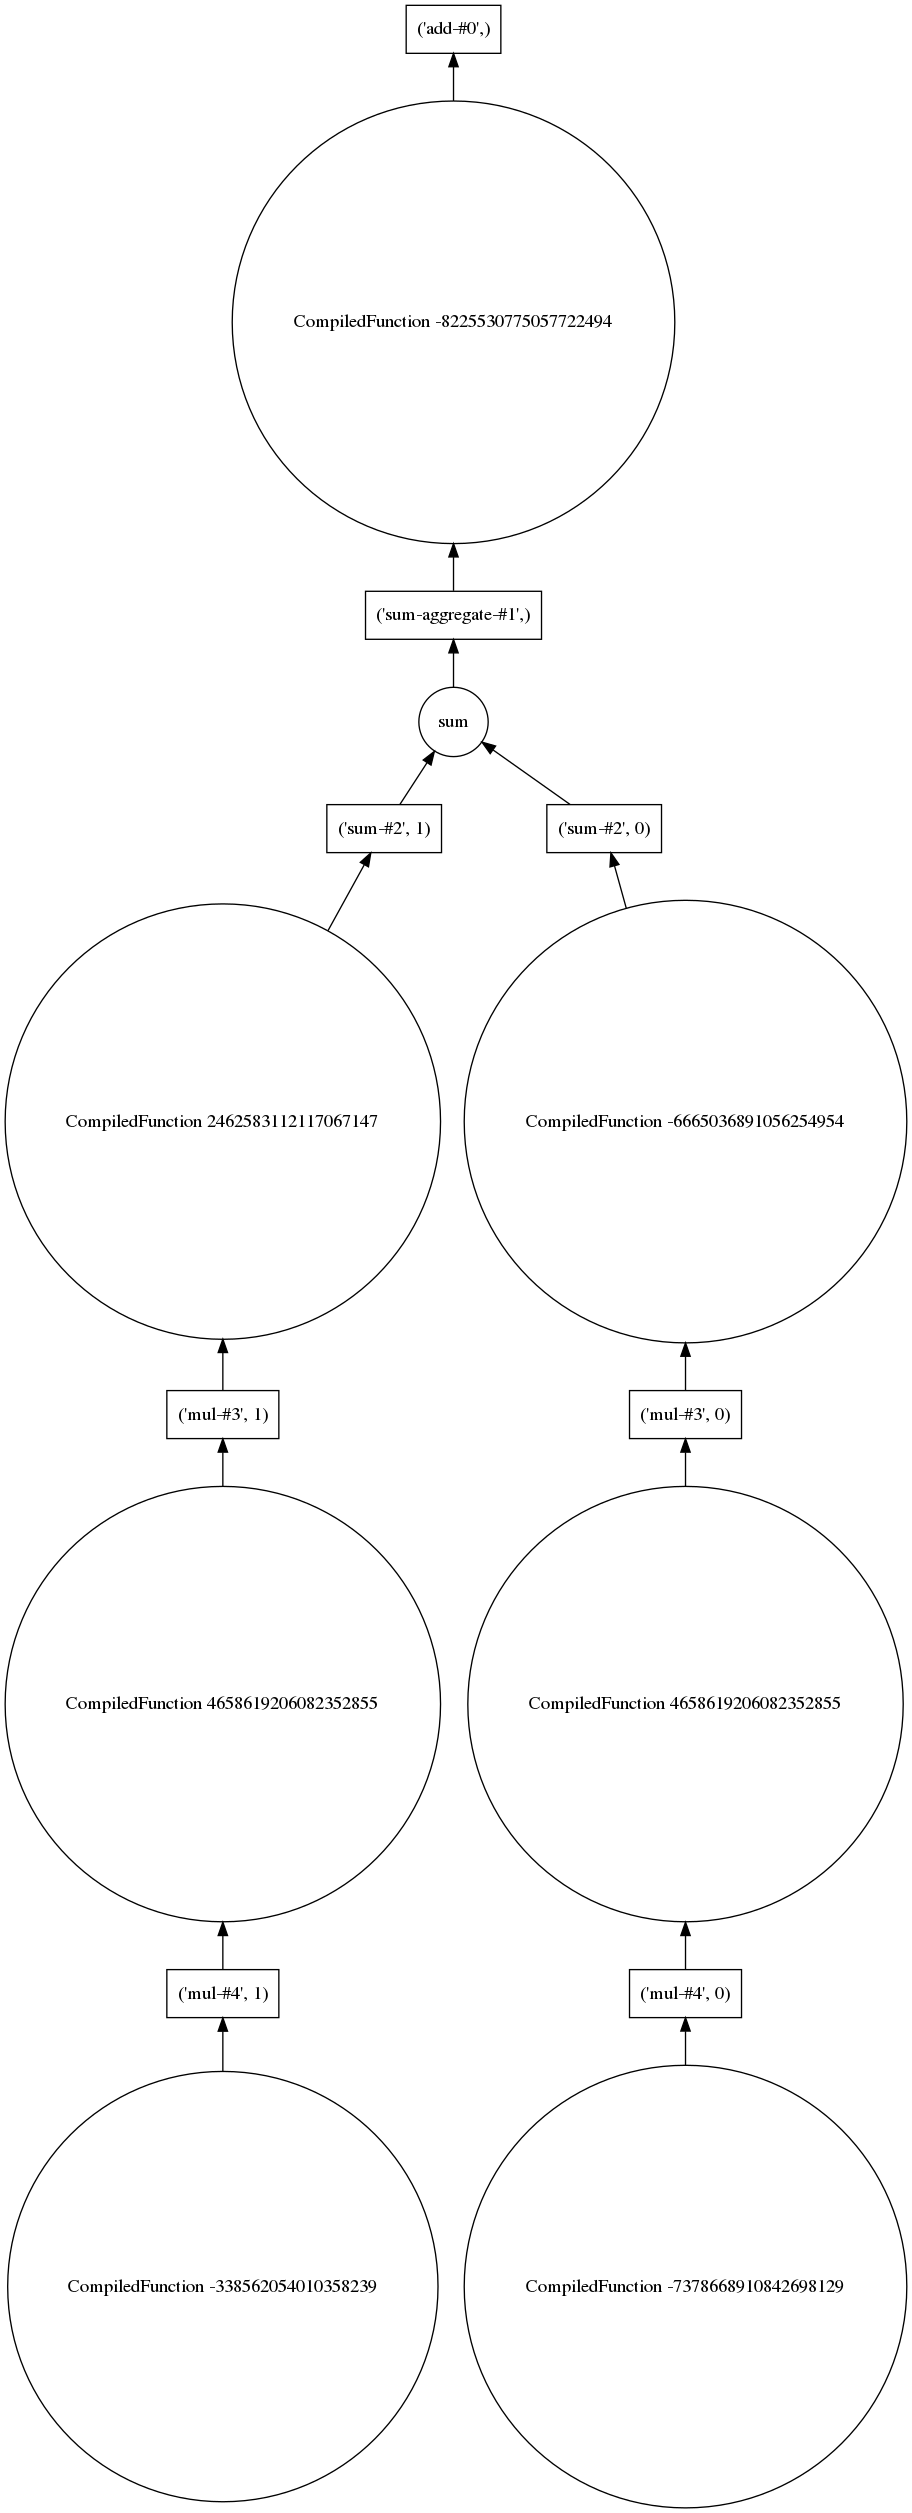

In [12]:
da_com.visualize()